In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import tensorboard as tb
import numpy as np

In [7]:
experiment_id = "nFp3SxltR4eelSmb99VwVQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

In [8]:
experiment_dict = {
    'ConvMixer': 'v20-normalized/07-01_1810_52_CvMx-h=1024-d=8-k=5-p=5_batch=256_lr=0.0001_mom=0.9_ReLU_AdamW_aug=2_wfn=linear-2000',
    'VisionTransformer': 't6-drops/07-06_1403_24_ViT_p=5_emb=256_d=8_heads=8_drop=0.1_attn-drop=0.0_path-drop=0.0_batch=128_lr=0.0001_AdamW_aug=2_wfn=linear-2000',
    'SwinTransformer': 's1-baseline/07-04_1242_30_Swin_p=4_emb=96_d=8_heads_12_drop=0.0_attn-drop=0.0_path-drop0.1_win=8_batch=256_lr=0.0001_AdamW_aug=2_wfn=linear-2000',
    'ConvMixer (base)': 'v9-pk_sizes/06-15_1311_18_CvMx-h=960-d=8-k=5-p=5_batch=256_lr=0.0001_mom=0.9_GELU_Ranger21_aug=2',
    'ResNet50': 'r2-normalized/07-01_1906_09_ResNet50_batch=1024_lr=0.0001_AdamW_aug=2_wfn=linear-2000',
    'ResNet18': 'r2-normalized/07-01_1921_20_ResNet18_batch=1024_lr=0.0001_AdamW_aug=2_wfn=linear-2000',
    # 'ConvChannelMixer': 'c1-cvchmx_baseline/07-15_2307_32_CvChMx-h=960-d=8-p=5_batch=256_lr=0.0001_mom=0.9_ReLU_AdamW_aug=2_CosAnLR-wfn=linear-2000',
    # 'ChannelMixer': 'c2-chmx_baseline/07-16_0325_48_ChMx-h=960-d=8-p=5_batch=128_lr=0.0001_mom=0.9_ReLU_AdamW_aug=2_CosAnLR-wfn=linear-2000' 
}

In [129]:
color_keys = ['b', 'g', 'r', 'c', 'm', 'y', 'k']


def get_plot_data_from_runs(runs, column='tag', equals='mAP-micro/valid'):

    data = {}
    for model_name, path in runs.items():
        exp = df.loc[(df['run'] == path) & (df[column] == equals)]
        data[model_name] = exp['value'].to_numpy()

    return data


def plot_data_dict(plot_data, leg_loc='lower right', metric='mAP-micro', split='validation', ylim=0.8, dpi=100):

    assert len(plot_data) <= len(color_keys), "Only 7 colors available but more plots as input."

    ax = plt.subplot()
    plt.title(f'{metric} on {split} data')
    plt.xlabel("epochs")
    plt.ylabel("mAP-micro")
    plt.ylim((ylim, 0.905))
    ax.yaxis.set_tick_params(labelright='off')
    ax.yaxis.set_ticks_position('both')

    for idx, data in enumerate(plot_data.items()):

        model_name = data[0]
        values = data[1]
        epoch_indices = range(len(values))

        plt.plot(epoch_indices, values, label=model_name, color=color_keys[idx])

    plt.gcf().set_dpi(dpi)
    plt.grid()
    plt.legend(loc=leg_loc)
    plt.show()

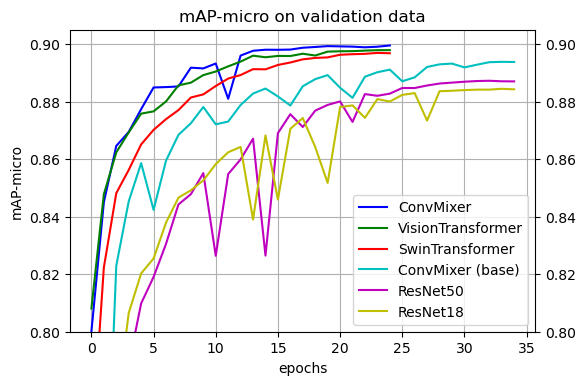

In [130]:
plot_data = get_plot_data_from_runs(experiment_dict)
plot_data_dict(plot_data=plot_data)

In [121]:
# plot test-perf vs train-time vs paramsize
efficiency_plt = {
    'ConvMixer': [.9011, 8921107, 12],
    'SwinTransformer': [.8987, 27603517, 18.5],
    'VisionTransformer': [.8999, 6535699, 24.6],
    'ChannelMixer': [.8916, 7426579, 17.1],
    'ConvChannelMixer': [.8909, 7656979, 16.5],
    'ResNet-50': [.8883, 23568915, 15.5],
}

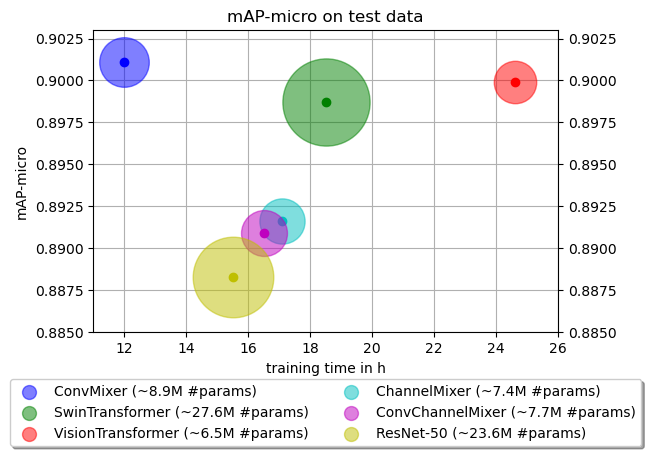

In [162]:
def plot_efficiency(plot_data, metric='mAP-micro', split='test', dpi=100):

    assert len(plot_data) <= len(color_keys), "Only 7 colors available but more plots as input."

    ax = plt.subplot()
    plt.title(f'{metric} on {split} data')
    plt.xlabel("training time in h")
    plt.ylabel("mAP-micro")
    plt.ylim((0.885, 0.903))
    plt.xlim((11, 26))
    ax.yaxis.set_tick_params(labelright='off')
    ax.yaxis.set_ticks_position('both')

    for idx, model_stats in enumerate(plot_data.items()):

        model_name, stats = model_stats
        normalized_size = stats[1]/7000
        plt.scatter([stats[2]], [stats[0]], label=f'{model_name} (~{stats[1]/1000000:.1f}M #params)', s=[normalized_size], color=color_keys[idx], alpha=0.5, zorder=3)
        plt.scatter([stats[2]], [stats[0]], color=color_keys[idx], alpha=1, zorder=3)

    lgnd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=2, shadow=True)
    for l in lgnd.legendHandles:
        l._sizes = [100]

    plt.grid(zorder=0)
    plt.gcf().set_dpi(dpi)
    plt.show()

plot_efficiency(efficiency_plt)